In [1]:
import os
import copy
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential

import hls4ml
from hls4ml.converters.keras_to_hls import parse_default_keras_layer
from hls4ml.model.attributes import ConfigurableAttribute, TypeAttribute
from hls4ml.model.types import FixedPrecisionType, RoundingMode, SaturationMode
from hls4ml.model.attributes import Attribute

import h5py

import qkeras as qk
from qkeras.estimate import print_qstats
from qkeras.utils import model_quantize
from qkeras.utils import quantized_model_dump
from qkeras import QActivation, QDense, QConv2DBatchnorm

# Source the Vivado path
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

np.random.seed(0)
tf.random.set_seed(0)


2025-07-01 16:01:49.334357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-01 16:01:49.417056: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-01 16:01:49.419994: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-07-01 16:01:49.420007: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

/home/aelabd/RHEED/hls4ml/hls4ml/converters/__init__.py:29: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Helper functions

In [2]:
from qkeras.autoqkeras.utils import print_qmodel_summary

def generate_binary_numbers(n_bits):
    return np.array([''.join(bits) for bits in itertools.product('01', repeat=n_bits)])


def ap_fixed_bin_to_float(bin_str: str, X: int, Y: int) -> np.float32:
    """
    Converts a binary string in two's complement ap_fixed<X,Y> format to a float.
    
    Parameters:
        bin_str (str): Binary string of length X.
        X (int): Total number of bits.
        Y (int): Number of integer bits (including sign bit).
        
    Returns:
        np.float32: Floating point value.
    """
    if len(bin_str) != X:
        raise ValueError(f"Binary string length ({len(bin_str)}) must match X ({X})")
    
    # Interpret binary string as signed integer
    int_val = int(bin_str, 2)
    if bin_str[0] == '1':  # Negative number (two's complement)
        int_val -= (1 << X)
    
    # Scale back by number of fractional bits
    frac_bits = X - Y
    value = int_val / (2 ** frac_bits)
    return np.float32(value)

def ap_ufixed_bin_to_float(bin_str: str, X: int, Y: int) -> np.float32:
    """
    Converts a binary string in two's complement ap_fixed<X,Y> format to a float.
    
    Parameters:
        bin_str (str): Binary string of length X.
        X (int): Total number of bits.
        Y (int): Number of integer bits (including sign bit).
        
    Returns:
        np.float32: Floating point value.
    """

    if bin_str[0] == '1':
        return ap_fixed_bin_to_float("0"+bin_str, X+1, Y+1)
    else:
        return ap_fixed_bin_to_float(bin_str, X, Y)


def float_to_ap_fixed(value, X, Y):
    """
    Converts a float to a binary string representing a signed ap_fixed<X,Y> number.
    
    Parameters:
        value (float): The float value to convert.
        X (int): Total number of bits.
        Y (int): Number of integer bits (including sign bit).
    
    Returns:
        str: Binary string of length X.
    """
    # Number of fractional bits
    F = X - Y

    # Compute scaled integer
    scaled = int(round(value * (2 ** F)))

    # Calculate min and max representable values
    min_val = -(2 ** (X - 1))
    max_val = (2 ** (X - 1)) - 1

    # Clip to representable range
    if scaled < min_val:
        scaled = min_val
    elif scaled > max_val:
        scaled = max_val

    # Convert to two's complement binary
    if scaled < 0:
        scaled = (1 << X) + scaled  # two's complement

    bin_str = format(scaled, f'0{X}b')  # zero-padded binary string of width X
    return bin_str

def ap_ufixed_hex_to_float(hex_str: str, X: int, Y: int):
    bin_str = bin(int(hex_str, 16)).replace("0b", "")
    n = len(bin_str)
    while n < X:
        bin_str = "0" + bin_str
        n = len(bin_str)
    return ap_ufixed_bin_to_float(bin_str, X, Y)

# 1. Load Keras model

In [3]:
KERAS_DIR = "/home/aelabd/RHEED/keras_models"
RTL_DIR = "/home/aelabd/RHEED/rtl_models"

def dice_loss(y_true, y_pred, delta=0.6):
    error = y_true - y_pred
    is_small = tf.abs(error) <= delta
    squared_loss = 0.5 * tf.square(error)
    linear_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.reduce_mean(tf.where(is_small, squared_loss, linear_loss))

fpath_model_keras = os.path.join(KERAS_DIR, "model_good1.keras")
with tf.keras.utils.custom_object_scope({'dice_loss': dice_loss,
                                         'QConv2DBatchnorm': QConv2DBatchnorm,
                                         'QActivation': QActivation,
                                         'QDense': QDense
                                         }):
        model = tf.keras.models.load_model(fpath_model_keras)

print_qmodel_summary(model)

2025-07-01 16:02:03.194938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-01 16:02:03.195227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-07-01 16:02:03.195368: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2025-07-01 16:02:03.195470: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2025-07-01 16:02:03.195564: W tensorf

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


q_conv2d_batchnorm   f=6 quantized_bits(8,0,0,alpha=1) quantized_bits(8,0,0,alpha=1) 
q_activation         quantized_relu(8, 2)
q_conv2d_batchnorm_1 f=8 quantized_bits(8,2,0,alpha=1) quantized_bits(8,2,0,alpha=1) 
q_activation_1       quantized_relu(8, 2)
q_conv2d_batchnorm_2 f=10 quantized_bits(8,2,0,alpha=1) quantized_bits(8,2,0,alpha=1) 
q_activation_2       quantized_relu(8, 2)
q_dense              u=15 quantized_bits(8,2,0,alpha=1) quantized_bits(8,2,0,alpha=1) 
q_activation_3       quantized_relu(8, 2)
q_dense_1            u=10 quantized_bits(8,2,0,alpha=1) quantized_bits(8,2,0,alpha=1) 
q_activation_4       quantized_relu(8, 2)
q_dense_2            u=5 quantized_bits(8,2,0,alpha=1) quantized_bits(8,2,0,alpha=1) 



# 2. Load testbench input data

[min, max]  = [0.0, 0.99609375]


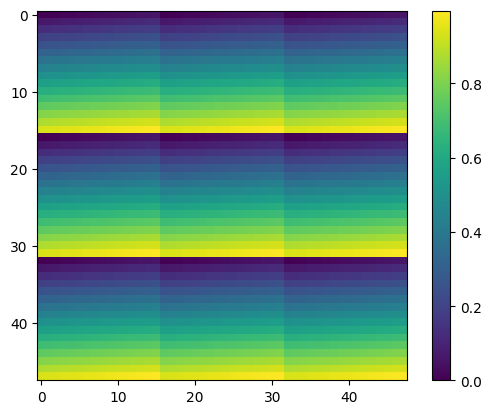

[min, max]  = [0.0, 0.99609375]


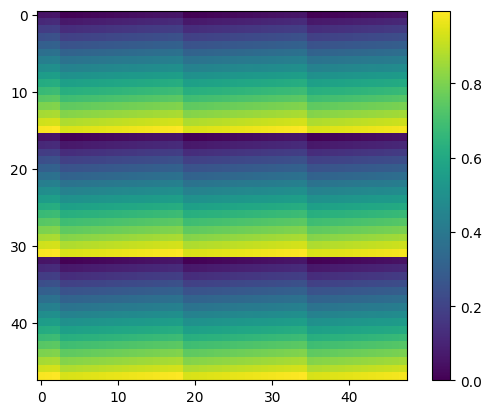

[min, max]  = [0.0, 0.99609375]


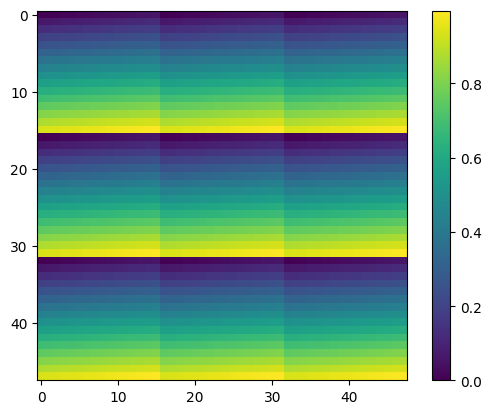

[min, max]  = [0.0, 0.99609375]


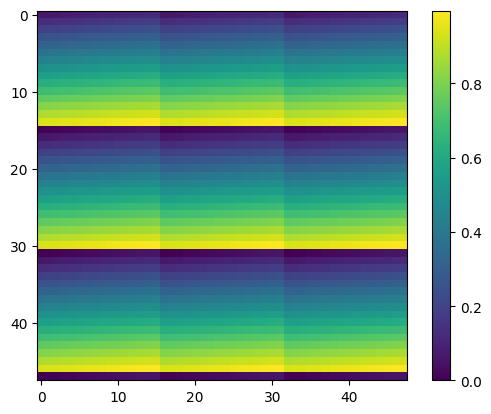

[min, max]  = [0.0, 0.99609375]


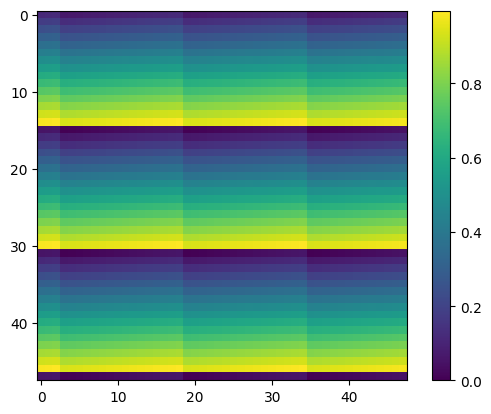

[min, max]  = [0.0, 0.99609375]


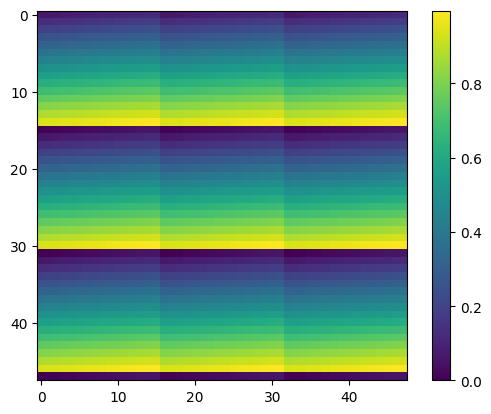

[min, max]  = [0.0, 0.99609375]


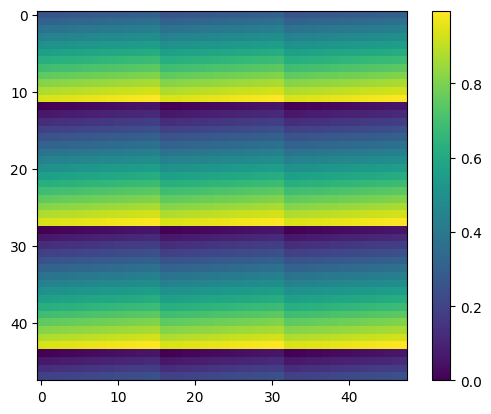

[min, max]  = [0.0, 0.99609375]


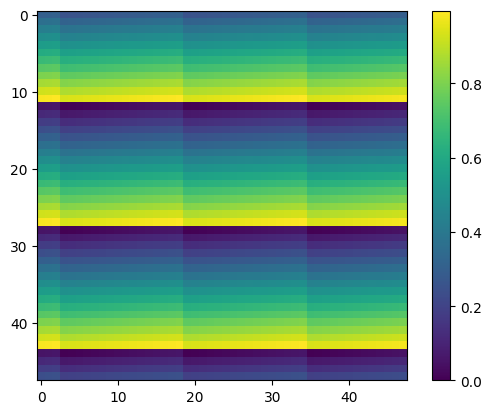

[min, max]  = [0.0, 0.99609375]


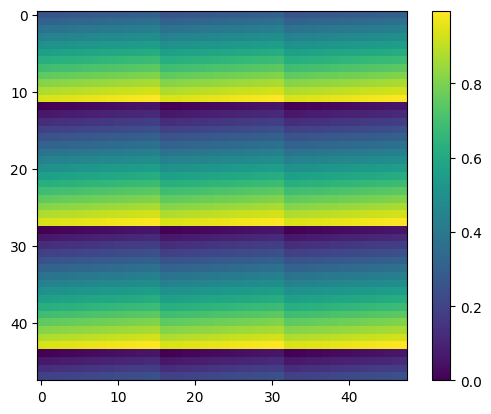

In [4]:
IN_ROWS = 100
IN_COLS = 160
OUT_ROWS = 48
OUT_COLS = 48
NUM_CROPS = 1
data_dir = f"tb_data_Mono8/{IN_ROWS}x{IN_COLS}_to_{OUT_ROWS}x{OUT_COLS}x{NUM_CROPS}"

CROP_X0 = [0, 13, 112]
CROP_Y0 = [0, 1, 52]
input_data = {}
for y0 in CROP_Y0:
    input_data[f"y1_{y0}"] = {}
    for x0 in CROP_X0:
        crop_data = []
        fpath = os.path.join(data_dir, f"Y1_{y0}/X1_{x0}/HDL_cropnorm_out.txt")
        with open(fpath, "r") as f:
            for line in f.readlines():

                line_float = np.zeros((OUT_COLS,))
                for i, hex_str in enumerate(line.split(" ")):
                    hex_str_clean = hex_str.replace("\n", "").replace(" ", "")
                    if len(hex_str_clean) < 1: continue
                    line_float[i] = ap_ufixed_hex_to_float(hex_str_clean, 8, 0)

                crop_data.append(line_float)

        input_data_float = np.expand_dims(np.expand_dims(np.array(crop_data), 0), 3)
        input_data[f"y1_{y0}"][f"x1_{x0}"] = input_data_float

        print(f"[min, max]  = [{np.min(np.min(input_data_float[0,:,:,0], axis=0), axis=0)}, {np.max(np.max(input_data_float[0,:,:,0], axis=0), axis=0)}]")
        plt.figure()
        plt.imshow(input_data_float[0,:,:,0], vmin=np.min(np.min(input_data_float[0,:,:,0], axis=0), axis=0), vmax=np.max(np.max(input_data_float[0,:,:,0], axis=0), axis=0))
        plt.colorbar()
        plt.show()
        plt.close()

# 3. Generate predictions

In [5]:
TOTAL_BITS = 22
INT_BITS = 11

In [6]:
pred_data = {}
output_data = {}
for y0 in CROP_Y0:
    pred_data[f"y1_{y0}"] = {}
    for x0 in CROP_X0:
        print(f"y0={y0}, x0={x0}")
        pred = model.predict(input_data[f"y1_{y0}"][f"x1_{x0}"])[0]
        pred_data[f"y1_{y0}"][f"x1_{x0}"] = pred
        fpath_txt = os.path.join(data_dir, f"Y1_{y0}/X1_{x0}/QKeras_mg1_pred_ap_fixed_{TOTAL_BITS}_{INT_BITS}.txt")
        with open(fpath_txt, "w") as f:
            for val in pred:
                bin_str = float_to_ap_fixed(val, TOTAL_BITS, INT_BITS)
                f.write(f"{bin_str}\n")
                print(f"val: {val}, bin_str: {bin_str}")

y0=0, x0=0
1/1 [==============================] - 0s 396ms/step
val: 0.279296875, bin_str: 0000000000001000111100
val: 0.4716796875, bin_str: 0000000000001111000110
val: 0.5654296875, bin_str: 0000000000010010000110
val: 0.4873046875, bin_str: 0000000000001111100110
val: 0.02099609375, bin_str: 0000000000000000101011
y0=0, x0=13
1/1 [==============================] - 0s 19ms/step
val: 0.28076171875, bin_str: 0000000000001000111111
val: 0.47216796875, bin_str: 0000000000001111000111
val: 0.56494140625, bin_str: 0000000000010010000101
val: 0.48583984375, bin_str: 0000000000001111100011
val: 0.01611328125, bin_str: 0000000000000000100001
y0=0, x0=112
1/1 [==============================] - 0s 18ms/step
val: 0.279296875, bin_str: 0000000000001000111100
val: 0.4716796875, bin_str: 0000000000001111000110
val: 0.5654296875, bin_str: 0000000000010010000110
val: 0.4873046875, bin_str: 0000000000001111100110
val: 0.02099609375, bin_str: 0000000000000000101011
y0=1, x0=0
1/1 [=====================